# Biomass Gasification

<p class="acknowledgement">Written by Prof. William Smith (University of Guelph) and Allan Leal (ETH Zurich) on Mar 31st, 2023</p>

This tutorial demonstrates the use of Reaktoro for biomass gasification in which temperature and exit gas composition are calculated from given Fuel Ultimate Analysis and fuel-to-air ratios.

In [2]:
from reaktoro import *
import numpy as np

In [3]:
db = NasaDatabase("nasa-cea")

In [4]:
# Inputs -----------------------------------------------------------------------------
massC              = 49.30  # g/mol
massH              = 5.5    # g/mol
massO              = 45.2   # g/mol
HHV                = 18.933 # kJ/g
Q                  = 0.05   # heat loss (%) with respect to HHV
fAirMin            = 0.70   # minimum value for fAir (fuel to air mass ratio)
fAirDelta          = 0.1    # step-size for fAir values
fAirNum            = 30     # number of steps for fAir
output_all_species = False   # if false, output only a few species
MC = 0.1
# ------------------------------------------------------------------------------------

In [50]:
fAirs = [fAirMin + i * fAirDelta for i in range(fAirNum)]

nC = massC / 12.011
nH = massH / 1.00797
nO = massO / 15.9994

h0CO2 = -393.522  # kJ/g
h0H2O_l = -285.83   # kJ/g
h0H2O_g = -241.26   # kJ/g
M_C, M_H, M_O, M_N = 12.011, 1.008, 15.999, 14.007  # kg/kmol
w_C = 0.521
w_H = 0.062
w_O = 0.412
w_N = 0.005
w_S = 0
a = w_H * M_C / (w_C * M_H)
b = w_O * M_C / (w_C * M_O)
c = w_N * M_C / (w_C * M_N)
y = MC * (12 + a * 1 + b * 16 ) / (2 * 1 + 16)
M_b = (M_C + a*M_H + b*M_O + c*M_N) # kg/kmol
HHV_b = (0.3491*w_C + 1.1783*w_H + 0.1005*w_S - 0.1034*w_O - 0.0151*w_N)*100*1000*M_b # kJ/kmol - higher heating value of biomass (multipled by 100, so mass fractions are in % - empirical equation)
dH_vap = -40.7e3 # kJ/kmol - enthalpy of water vaporization

formula = ChemicalFormula(f"C{0.95}H{a}O{b}N{c}")

Mfuel = formula.molarMass() * 1000  # from kg/mol to g/mol
Mair = 28.850334  # in g/mol

factor = Mfuel / Mair

HHVmol = HHV * Mfuel
HHVmol

425.1091426854813

In [52]:
h0fuel = HHV_b/1000 + h0CO2 + 0.5*h0H2O_l*a  # in kJ/kmol
heatDuty = h0fuel + y*(h0H2O_g + dH_vap/1000)# in kJ/kmol
heatDuty

-142.73418951962535

In [54]:
stmodelparams = StandardThermoModelParamsConstant()
stmodelparams.G0 = 1.0e+3
stmodel = StandardThermoModelConstant(stmodelparams)

species = Species()
species = species.withName("Fuel")
species = species.withElements(formula.elements())
species = species.withAggregateState(AggregateState.CondensedPhase)
species = species.withStandardThermoModel(stmodel)

db.addSpecies(species)

In [56]:
gases = GaseousPhase(speciate("C H O N"))
condensedphases = CondensedPhases("Fuel H2O(l)")

system = ChemicalSystem(db, condensedphases, gases)

In [58]:
specs = EquilibriumSpecs(system)
specs.pressure()
specs.enthalpy()

solver = EquilibriumSolver(specs)

In [77]:
temperatures = []

table = Table()

#phi_Os = np.arange(0.21,0.96, 0.01)
#ER = 0.3
phi_O = 0.21
ERs = np.arange(0.1, 0.61, 0.01)
for ER in ERs:
    phi_N = 1 - phi_O
    state = ChemicalState(system)
    state.temperature(25.0, "°C")
    state.pressure(1.0, "bar")
    state.set("Fuel", 1.0, "mol")
    state.set('H2O', y, 'mol')
    state.set("O2", ER*(1 + a/4 - b/2), "mol")
    state.set("N2", ER*(1 + a/4 - b/2)*phi_N/phi_O, "mol")

    props = ChemicalProps(state)
    conditions = EquilibriumConditions(specs)

    conditions.pressure(props.pressure())
    conditions.enthalpy(heatDuty, "kJ")

    conditions.setLowerBoundTemperature(298.15, "°C")
    conditions.setUpperBoundTemperature(3000.0, "°C")

    result = solver.solve(state, conditions)

    assert result.succeeded()

    table.column("ER") << ER
    table.column("phi_O") << phi_O
    table.column("Temperature") << state.temperature()
    table.column(f"n(Gases)") << state.props().phaseProps("GaseousPhase").amount() - state.speciesAmount("H2O")
    
    if output_all_species:
        for species in system.species():
            table.column(f"n({species.name()})") << state.speciesAmount(species.name())
    else:
        #table.column("n(C(gr))")    << state.speciesAmount("C(gr)")
        table.column("n(CH4)")      << state.speciesAmount("CH4")
        table.column("n(CO)")       << state.speciesAmount("CO")
        table.column("n(CO2)")      << state.speciesAmount("CO2")
        table.column("n(H2)")       << state.speciesAmount("H2")
        table.column("n(H2O)")      << state.speciesAmount("H2O")
        table.column("n(N2)")       << state.speciesAmount("N2")

In [78]:
table.save("output_ER.txt")

We now plot the calculated temperatures of the exit stream as a function of the fuel-to-air mass ratio.

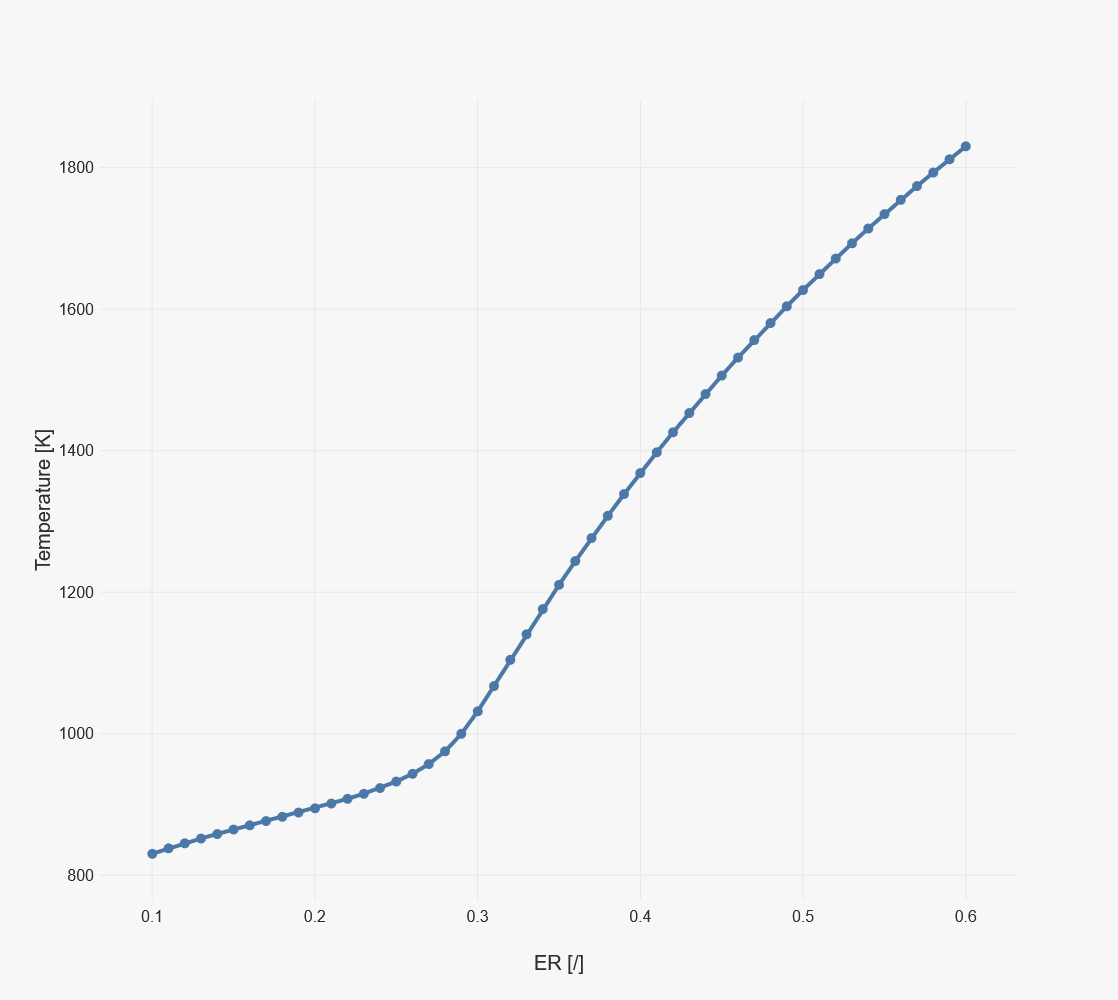

In [80]:
from reaktplot import *

fig = Figure()
fig.xaxisTitle("ER [/]")
fig.yaxisTitle("Temperature [K]")
fig.drawLineWithMarkers(table['ER'], table["Temperature"], name="temp")
n_tot = table["n(Gases)"]
n_tot = np.array(n_tot)
'''
fig.drawLineWithMarkers(table['phi_O'], table["n(CH4)"]/n_tot, name="n(CH4")
fig.drawLineWithMarkers(table['phi_O'], table["n(CO)"]/n_tot, name="n(CO)")
fig.drawLineWithMarkers(table['phi_O'], table["n(CO2)"]/n_tot, name="n(CO2)")
fig.drawLineWithMarkers(table['phi_O'], table["n(N2)"]/n_tot, name="n(N2)")
fig.drawLineWithMarkers(table['phi_O'], table["n(H2)"]/n_tot, name="n(H2)")
'''
fig.height(1000)
fig.show()
fig.save('figure.png')
#n_tot